In [21]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import nltk

# Download NLTK resources (only needs to be run once)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

# Load CSV file
df = pd.read_csv("../data/post_comments.csv")

# Remove empty comments and hashtags
df = df[df["text"].notna()]
df["text"] = df["text"].astype(str).apply(lambda x: re.sub(r"#\w+", "", x).strip())

# Convert timestamp column to datetime
df["createTimeISO"] = pd.to_datetime(df["createTimeISO"])

[nltk_data] Downloading package punkt to C:\Users\Surface/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Surface/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Surface/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Filtering and outliers

In [22]:
# Filter to last 6 months
from datetime import datetime
six_months_ago = pd.Timestamp(datetime.today() - pd.DateOffset(months=6), tz="UTC")
df = df[df["createTimeISO"] >= six_months_ago]

# Remove very long comments (e.g. spam or repeated text blocks)
df = df[df["text"].str.split().str.len() < 100]

# Remove comments with excessive repetition of a single word
def has_repeated_word(text, threshold=5):
    words = text.lower().split()
    word_counts = Counter(words)
    return any(count >= threshold for count in word_counts.values())

df = df[~df["text"].apply(has_repeated_word)]

Stopwords and tokenization

In [23]:
# Define standard and custom stopwords
standard_stopwords = set(stopwords.words("german")) | set(stopwords.words("english"))
custom_stopwords = {
    "i", "you", "it", "me", "this", "that", "we", "she", "he", "they", "u", "ur",
    "my", "your", "yours", "ours", "their", "its", "use", "like", "get", "need", 
    "please", "one", "would", "watch", "want", "que", "tbh", "idk", "fr", 
    "literally", "actually", "honestly", "kinda", "thing", "stuff", "good", "bad", 
    "😭", "😂", "✨", "💀", "💅", "🥰", "😩", "😅", "🥺", "😳"
}

# Unigram-specific stopwords (standard + custom)
combined_stopwords = standard_stopwords | custom_stopwords

# Clean + tokenize for unigram analysis
def clean_tokens_unigrams(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)
    tokens = word_tokenize(text)
    return [w for w in tokens if w not in combined_stopwords and len(w) > 2]

# Clean + tokenize for n-gram analysis (no custom stopwords)
def clean_tokens_ngrams(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)
    tokens = word_tokenize(text)
    return [w for w in tokens if w not in standard_stopwords and len(w) > 2]

# Apply both tokenizations
df["unigram_tokens"] = df["text"].apply(clean_tokens_unigrams)
df["ngram_tokens"] = df["text"].apply(clean_tokens_ngrams)

# Recompute flattened ngram lists from tokenized columns
all_unigrams = [word for tokens in df["unigram_tokens"] for word in tokens]
all_bigrams = [" ".join(bg) for tokens in df["ngram_tokens"] for bg in ngrams(tokens, 2)]
all_trigrams = [" ".join(tg) for tokens in df["ngram_tokens"] for tg in ngrams(tokens, 3)]


Most common words

In [24]:
# Get top 10 of each ngram type
top10_unigrams = Counter(all_unigrams).most_common(10)
top10_bigrams = Counter(all_bigrams).most_common(10)
top10_trigrams = Counter(all_trigrams).most_common(10)

# Convert to separate DataFrames
df_uni = pd.DataFrame(top10_unigrams, columns=["Unigram", "Unigram Count"])
df_bi = pd.DataFrame(top10_bigrams, columns=["Bigram", "Bigram Count"])
df_tri = pd.DataFrame(top10_trigrams, columns=["Trigram", "Trigram Count"])

# Combine side-by-side
df_side_by_side = pd.concat([df_uni, df_bi, df_tri], axis=1)

# Display the result
df_side_by_side


,Unigram,Unigram Count,Bigram,Bigram Count,Trigram,Trigram Count
0,skin,6476,skin care,772,acne prone skin,145
1,love,3581,skincare routine,339,skin care routine,136
2,skincare,2595,cleansing oil,329,instagram sagajewels official,72
3,face,1824,cleaning fyp,314,korean skin care,68
4,routine,1430,look like,299,would anyone watch,67
5,acne,1424,oily skin,289,anua cleansing oil,62
6,products,1407,sensitive skin,267,anyone watch grwm,59
7,serum,1223,korean skincare,262,izin ambil post,55
8,girl,1167,commenting stay,253,skin looks amazing,52
9,care,1118,dry skin,229,oily acne prone,51


Most common words this week

In [25]:
# Get most recent week
latest_week = df["createTimeISO"].dt.to_period("W").max().start_time

# Filter DataFrame to only the latest week
df_latest = df[df["createTimeISO"].dt.to_period("W").dt.start_time == latest_week]

# Extract tokens
unigrams_latest = [word for tokens in df_latest["unigram_tokens"] for word in tokens]
bigrams_latest = [" ".join(bg) for tokens in df_latest["ngram_tokens"] for bg in ngrams(tokens, 2)]
trigrams_latest = [" ".join(tg) for tokens in df_latest["ngram_tokens"] for tg in ngrams(tokens, 3)]

# Count top 10
top10_unigrams = Counter(unigrams_latest).most_common(10)
top10_bigrams = Counter(bigrams_latest).most_common(10)
top10_trigrams = Counter(trigrams_latest).most_common(10)

# Total counts for relative frequency
total_unigrams = sum(Counter(unigrams_latest).values())
total_bigrams = sum(Counter(bigrams_latest).values())
total_trigrams = sum(Counter(trigrams_latest).values())

# Convert to DataFrames with percentages
df_uni = pd.DataFrame(top10_unigrams, columns=["Unigram", "Unigram Count"])
df_uni["Unigram %"] = (df_uni["Unigram Count"] / total_unigrams) * 100

df_bi = pd.DataFrame(top10_bigrams, columns=["Bigram", "Bigram Count"])
df_bi["Bigram %"] = (df_bi["Bigram Count"] / total_bigrams) * 100

df_tri = pd.DataFrame(top10_trigrams, columns=["Trigram", "Trigram Count"])
df_tri["Trigram %"] = (df_tri["Trigram Count"] / total_trigrams) * 100

# Keep only relevant columns
df_uni = df_uni[["Unigram", "Unigram %"]]
df_bi = df_bi[["Bigram", "Bigram %"]]
df_tri = df_tri[["Trigram", "Trigram %"]]

# Combine side-by-side and round percentages
df_relative_latest_week = pd.concat([df_uni, df_bi, df_tri], axis=1).round(2)

# Display headline and info
print("Top 10 Ngrams (Relative Frequencies) – Latest Week")
print(f"Week starting: {latest_week.strftime('%Y-%m-%d')}\n")

# Show the table
df_relative_latest_week


C:\Users\Surface\AppData\Local\Temp\ipykernel_20328\3785980428.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  latest_week = df["createTimeISO"].dt.to_period("W").max().start_time
C:\Users\Surface\AppData\Local\Temp\ipykernel_20328\3785980428.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_latest = df[df["createTimeISO"].dt.to_period("W").dt.start_time == latest_week]


Top 10 Ngrams (Relative Frequencies) – Latest Week
Week starting: 2025-04-07



,Unigram,Unigram %,Bigram,Bigram %,Trigram,Trigram %
0,skin,1.81,izin ambil,0.58,izin ambil post,0.33
1,fyp,1.55,skin care,0.42,first time seeing,0.30
2,love,0.96,first time,0.39,skin care routine,0.19
3,skincare,0.94,fyp fam,0.36,hello beauty cute,0.15
4,face,0.78,cleaning fyp,0.36,beauty cute wow,0.15
5,aku,0.71,andrea fyp,0.31,time andrea fyp,0.15
6,izin,0.66,ambil post,0.25,time seeing andrea,0.15
7,kak,0.59,time seeing,0.22,seeing andrea fyp,0.15
8,ambil,0.57,care routine,0.19,first time andrea,0.11
9,time,0.57,commenting stay,0.17,izin ambil kak,0.11


Trends over time

In [26]:
# Convert datetime to week (if not already present)
df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time

# Generate bigrams and trigrams from ngram_tokens
df["bigrams"] = df["ngram_tokens"].apply(lambda tokens: [" ".join(g) for g in ngrams(tokens, 2)])
df["trigrams"] = df["ngram_tokens"].apply(lambda tokens: [" ".join(g) for g in ngrams(tokens, 3)])

# Combine unigrams, bigrams, and trigrams into one list per comment
df["all_ngrams"] = df["unigram_tokens"] + df["bigrams"] + df["trigrams"]

# Create flat list of (week, ngram) pairs
records = [
    (row["week"], ngram)
    for _, row in df.iterrows()
    for ngram in row["all_ngrams"]
]

df_all = pd.DataFrame(records, columns=["week", "ngram"])

# Count ngram mentions per week
weekly_counts = df_all.groupby(["week", "ngram"]).size().reset_index(name="count")

# Total number of comments per week
comments_per_week = df.groupby("week")["text"].count().reset_index(name="total_comments")

# Merge and normalize counts
weekly_counts = weekly_counts.merge(comments_per_week, on="week", how="left")
weekly_counts["mention_percent"] = (weekly_counts["count"] / weekly_counts["total_comments"]) * 100

C:\Users\Surface\AppData\Local\Temp\ipykernel_20328\2807557589.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time


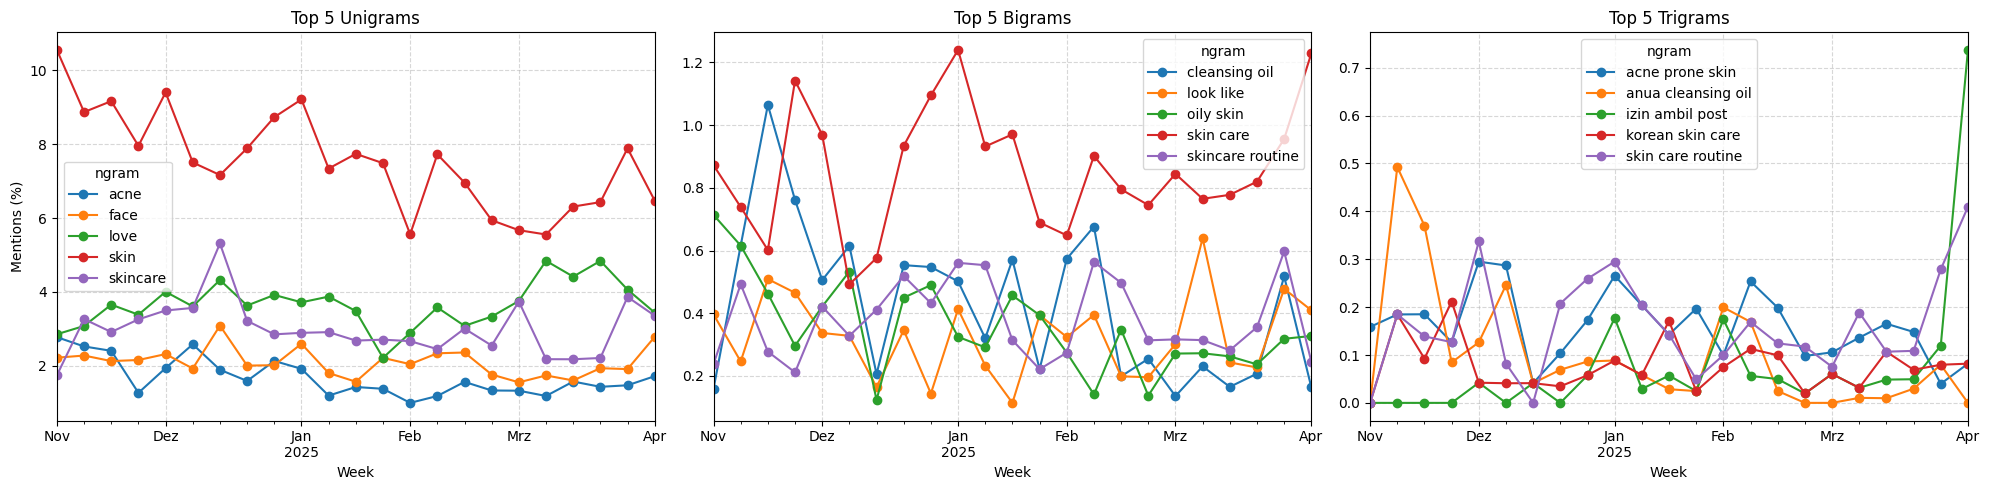

In [27]:
# Helper function: classify ngram by type based on number of words
def get_ngram_type(ngram):
    if len(ngram.split()) == 1:
        return "Unigram"
    elif len(ngram.split()) == 2:
        return "Bigram"
    else:
        return "Trigram"

# Assign ngram type to each row
weekly_counts["type"] = weekly_counts["ngram"].apply(get_ngram_type)

# Get top 5 ngrams per type based on total percentage over time
top_ngrams_by_type = (
    weekly_counts.groupby(["type", "ngram"])["mention_percent"]
    .sum()
    .reset_index()
    .sort_values(["type", "mention_percent"], ascending=[True, False])
    .groupby("type")
    .head(5)
)

# Filter weekly_counts to include only top 5 ngrams per type
top_weekly = weekly_counts.merge(top_ngrams_by_type[["type", "ngram"]], on=["type", "ngram"])

# Create pivot tables for each ngram type
df_uni = top_weekly[top_weekly["type"] == "Unigram"].pivot(index="week", columns="ngram", values="mention_percent").fillna(0)
df_bi = top_weekly[top_weekly["type"] == "Bigram"].pivot(index="week", columns="ngram", values="mention_percent").fillna(0)
df_tri = top_weekly[top_weekly["type"] == "Trigram"].pivot(index="week", columns="ngram", values="mention_percent").fillna(0)

# Create subplots: one for each ngram type
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot Unigrams
df_uni.plot(ax=axes[0], marker="o")
axes[0].set_title("Top 5 Unigrams")
axes[0].set_xlabel("Week")
axes[0].set_ylabel("Mentions (%)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Plot Bigrams
df_bi.plot(ax=axes[1], marker="o")
axes[1].set_title("Top 5 Bigrams")
axes[1].set_xlabel("Week")
axes[1].grid(True, linestyle="--", alpha=0.5)

# Plot Trigrams
df_tri.plot(ax=axes[2], marker="o")
axes[2].set_title("Top 5 Trigrams")
axes[2].set_xlabel("Week")
axes[2].grid(True, linestyle="--", alpha=0.5)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


Note: percentage of comments per week that mention each of the top 5 ngrams (unigrams, bigrams, or trigrams). Values represent the share of total weekly comments containing the respective term, not total mention counts.

Most common chunks in comments

In [28]:
#import spacy
#from collections import Counter
#from langdetect import detect, DetectorFactory
#DetectorFactory.seed = 0  # For reproducibility
#import re

# Load spaCy models
#nlp_de = spacy.load("de_core_news_sm")
#nlp_en = spacy.load("en_core_web_sm")

# Emoji pattern
#emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)

# Normalize stopwords
#combined_stopwords = {w.lower().strip() for w in combined_stopwords}

# Function to extract valid multi-word noun chunks
#def extract_chunks(text, nlp_model):
#    doc = nlp_model(text)
#    chunks = []
#    for chunk in doc.noun_chunks:
#        chunk_text = chunk.text.lower().strip()
#        if emoji_pattern.search(chunk_text):
#            continue
#        words = chunk_text.split()
#        if len(words) < 2:
#            continue
#        if all(word in combined_stopwords for word in words):
#            continue
#        chunks.append(chunk_text)
#    return chunks

# Collect chunks
#all_chunks = []

# Analyze first 1000 comments
#for text in df["text"].dropna().head(5000):
#    text = text.strip()
#    if not text:
#        continue
#    try:
#        lang = detect(text)
#        if lang not in ["en", "de"]:
#            continue  # Skip non-English and non-German comments
#    except:
#        continue
#    model = nlp_de if lang == "de" else nlp_en
#    chunks = extract_chunks(text, model)
#    all_chunks.extend(chunks)

# Count and display top 20
#chunk_counter = Counter(all_chunks)

#print("\nTop 20 Chunks:")
#for chunk, count in chunk_counter.most_common(20):
#    print(f"{chunk}: {count}")



Note: chunk analysis doesn't provide significant insights compared to uni-,bi-,trigrams